# Nuevo código

In [4]:
# Bibliotecas a usar
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv

In [5]:
paths = glob.glob("../extdata/all-mias/*.pgm")
paths[0:5]

['../extdata/all-mias/mdb035.pgm',
 '../extdata/all-mias/mdb103.pgm',
 '../extdata/all-mias/mdb075.pgm',
 '../extdata/all-mias/mdb050.pgm',
 '../extdata/all-mias/mdb169.pgm']

In [16]:
class MIAS:
    def __init__(self, path):
        self.ref = re.search("mdb[0-9]{3}", path).group()
        img = cv.imread(path, cv.IMREAD_REDUCED_GRAYSCALE_4)
        self.img = cv.medianBlur(img, 3)

    def plot(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()

    def __repr__(self):
        self.plot()
        return self.ref

    def __print__(self):
        return self.__repr__()

    def __getitem__(self, index):
        return self.img[index]

In [123]:
class CleanBg():
    def __init__(self, mdb, ksize=(5, 5)):
        self.mdb = mdb
        # Creación del kernel compuesto por un disco de radio 2
        self.kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize)
        self.kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0

    # Obtener del umbral a partir del valor del nivel de gris en la imagen
    def T(self):
        hist = cv.calcHist([self.mdb.img], [0], None, histSize=[256],
                           ranges=(0, 256), accumulate=False)
        H_n = hist.astype(int).ravel()
        T = 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)
        return np.uint8(T)

    # Binarizar la imagen
    def bin(self):
        img_bin = self.mdb.img.copy()
        T = self.T()
        with np.nditer(img_bin, op_flags=['readwrite']) as it:
            for x in it:
                x[...] = 1 if x >= T else 0
        return cv.morphologyEx(img_bin, cv.MORPH_OPEN, self.kernel)

    # Obtener una imagen binarizada a partir de otra mostrando una región
    # específica seleccionada
    def get_region(self, region=('bg', 'fg')):
        # Ejecutar un análisis de componentes conectadas para extraer los
        # objetos de la imagen
        img_bin = self.bin()
        num_labs, labs, stats, centroids = \
            cv.connectedComponentsWithStats(img_bin, connectivity=4,
                                            ltype=cv.CV_16U)
        # Índices de todos los objetos encontrados
        objects = np.arange(num_labs)
        # Extraer el objeto más grande (con área mayor)
        max_obj = np.argmax(stats[1::, 4]) + 1
        # Extraer la imagen binarizada elegida
        img_region = labs.copy().astype(np.uint8)
        if region == 'fg':
            with np.nditer(img_region, op_flags=['readwrite']) as it:
                for x in it:
                    x[...] = 1 if x == max_obj else 0
            return img_region
        elif region == 'bg':
            # Extraer el fondo, incluyendo los objetos más pequeños
            bg_obj = np.ma.array(objects, mask=False)
            bg_obj.mask[max_obj] = True
            bg_obj = bg_obj.compressed()
            with np.nditer(img_region, op_flags=['readwrite']) as it:
                for x in it:
                    x[...] = 1 if x in bg_obj else 0
            return img_region

    # Limpiar el fondo de la imagen
    def clean_bg(self):
        img_bin = self.bin()
        # Obtener la región que no pertenece a la región del busto
        bg_region = self.get_region(region='bg')
        # Modificar las intensidades que no pertenecen a la región del busto
        img_clean = self.mdb.img.copy()
        with np.nditer(bg_region, flags=['multi_index']) as it:
            for x in it:
                if x:
                    img_clean[it.multi_index] = 0
        return img_clean

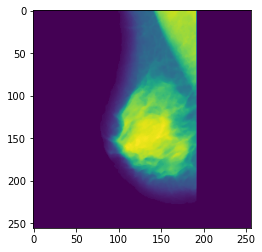

In [125]:
ex = MIAS(paths[41])
a = CleanBg(ex)
#plt.imshow(a.get_region(region='bg'), cmap='gray')
plt.imshow(a.clean_bg())

# Código antiguo

In [ ]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from scipy.integrate import quad
from scipy.special import beta
from scipy.interpolate import CubicSpline

In [ ]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def c(img):
    hist = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return local_minimum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= c(img), 1, 0).astype(np.uint8)

In [ ]:
local_minimum(np.array([23, 1, 6, 5, 0]))

In [ ]:
?np.argmin

In [ ]:
img_p = imgs_clean[41].copy().astype(float)
img_p[0][46]

In [ ]:
img_p = imgs_clean[1].copy().astype(float)
img_p *= 1/float(255)
img_p = np.float32(img_p)

# Hacemos una copia de la imagen limpia 51
a = 5
b = 4

def BDF(t):
    return (t ** (a - 1)) * ((1 - t) ** (b - 1))

with np.nditer(img_p, op_flags=['readwrite']) as it:
    for x in it:
        x[...], _ = quad(BDF, 0, x) / beta(a, b)
        
plt.imshow(img_p, cmap='gray')

In [ ]:
m = np.count_nonzero(img_p)

mu_k = (1 / m) * np.sum(img_p)
mu_k

In [ ]:
edge = np.zeros(img_p.shape)
coords = []

for i, row in enumerate(img_p):
    bina = np.where(np.logical_and(row < mu_k, row != 0), 0, 1)
    first_pix = np.argmin(bina) if np.any(bina == 0) else np.inf
    if first_pix < np.inf:
        coord = (i, first_pix)
        coords.append(coord)
        edge[coord] = 1.0
    
plt.imshow(edge, cmap='gray')

In [ ]:
CubicSpline(edge[])